# Assignment 1 - Building a Vision Model with Keras

In this assignment, you will build a simple vision model using Keras. The goal is to classify images from the Fashion MNIST dataset, which contains images of clothing items.

You will:
1. Load and inspect the Fashion MNIST dataset.
2. Run a simple baseline model to establish a performance benchmark.
3. Build and evaluate a simple CNN model, choosing appropriate loss and metrics.
4. Design and run controlled experiments on one hyperparameter (e.g., number of filters, kernel size, etc.) and one regularization technique (e.g., dropout, L2 regularization).
5. Analyze the results and visualize the model's performance.

# 1. Loading and Inspecting the Dataset

Fashion MNIST is a dataset of grayscale images of clothing items, with 10 classes. Each image is 28x28 pixels, like the MNIST dataset of handwritten digits. Keras provides a convenient way to load this dataset. 

In this section, you should:

- [ ] Inspect the shapes of the training and test sets to confirm their size and structure.
- [ ] Convert the labels to one-hot encoded format if necessary. (There is a utility function in Keras for this.)
- [ ] Visualize a few images from the dataset to understand what the data looks like.

In [5]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Classes in the Fashion MNIST dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [6]:
# Inspect the shapes of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)



X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


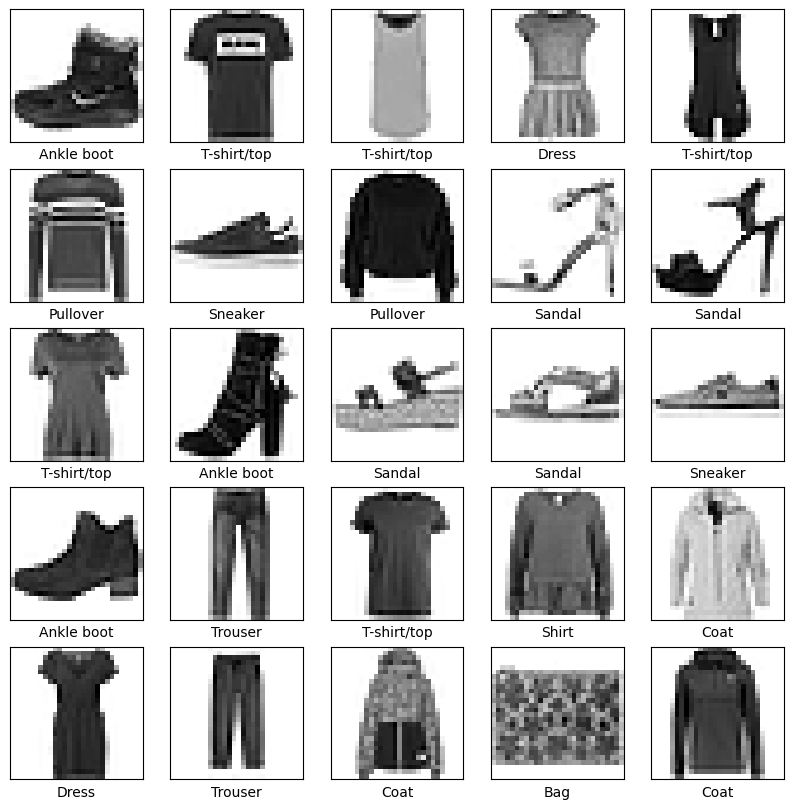

In [7]:
import matplotlib.pyplot as plt
# Verify the data looks as expected
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])


Reflection: Does the data look as expected? How is the quality of the images? Are there any issues with the dataset that you notice?

**Your answer here**

# 2. Baseline Model

In this section, you will create a linear regression model as a baseline. This model will not use any convolutional layers, but it will help you understand the performance of a simple model on this dataset.
You should:
- [ ] Create a simple linear regression model using Keras.
- [ ] Compile the model with an appropriate loss function and optimizer.
- [ ] Train the model on the training set and evaluate it on the test set.

A linear regression model can be created using the `Sequential` API in Keras. Using a single `Dense` layer with no activation function is equivalent to a simple linear regression model. Make sure that the number of units in the output layer matches the number of classes in the dataset.

Note that for this step, we will need to use `Flatten` to convert the 2D images into 1D vectors before passing them to the model. Put a `Flatten()` layer as the first layer in your model so that the 2D image data can be flattened into 1D vectors.

In [17]:
from keras.models import Sequential
from keras.layers import Dense


# Simple linear model (no convolution, just Dense layers)
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(784,)))  # 28*28=784
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
model.fit(
    X_train.reshape(-1, 784),  # Flatten the images
    y_train_onehot,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)
# Evaluate the model
loss, accuracy = model.evaluate(X_test.reshape(-1, 784), y_test_onehot)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                50240     
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5337 - accuracy: 0.8103 - val_loss: 0.4094 - val_accuracy: 0.8530
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3920 - accuracy: 0.8574 - val_loss: 0.3757 - val_accuracy: 0.8639
Epoch 3/10
1500/1500 [====

Reflection: What is the performance of the baseline model? How does it compare to what you expected? Why do you think the performance is at this level?

**Your answer here**

In [ ]:
# the performance of the baseline model is okay with an accuracy of around 85% on the initial training set. It does increase with more epochs
# close to 88% but far from high 90s we would expect. 

# 3. Building and Evaluating a Simple CNN Model

In this section, you will build a simple Convolutional Neural Network (CNN) model using Keras. A convolutional neural network is a type of deep learning model that is particularly effective for image classification tasks. Unlike the basic neural networks we have built in the labs, CNNs can accept images as input without needing to flatten them into vectors.

You should:
- [ ] Build a simple CNN model with at least one convolutional layer (to learn spatial hierarchies in images) and one fully connected layer (to make predictions).
- [ ] Compile the model with an appropriate loss function and metrics for a multi-class classification problem.
- [ ] Train the model on the training set and evaluate it on the test set.

Convolutional layers are designed to accept inputs with three dimensions: height, width and channels (e.g., RGB for color images). For grayscale images like those in Fashion MNIST, the input shape will be (28, 28, 1).

When you progress from the convolutional layers to the fully connected layers, you will need to flatten the output of the convolutional layers. This can be done using the `Flatten` layer in Keras, which doesn't require any parameters.

In [24]:
from keras.layers import Conv2D
from keras.layers import Flatten

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Create a simple CNN model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()
# Train the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Evaluate the model
model.fit(
    X_train,  # No need to flatten the images as done previously
    y_train_onehot,
    epochs=2,
    batch_size=32,
    validation_split=0.2
)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 flatten_2 (Flatten)         (None, 10816)             0         
                                                                 
 dense_38 (Dense)            (None, 32)                346144    
                                                                 
 dense_39 (Dense)            (None, 10)                330       
                                                                 
Total params: 346,634
Trainable params: 346,634
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1500/1500 [==============================] - 38s 25ms/step - loss: 0.4544 - accuracy: 0.8425 - val_loss: 0.3759 - val_accuracy: 0.8637
Epoch 2/2
1500/1500 [=============

Reflection: Did the CNN model perform better than the baseline model? If so, by how much? What do you think contributed to this improvement?

**Your answer here**

In [ ]:
# Model performance improved with CNN, accuracy around 90%. I had to reduce the epochs to 2 to avoid long training time.

# 3. Designing and Running Controlled Experiments

In this section, you will design and run controlled experiments to improve the model's performance. You will focus on one hyperparameter and one regularization technique.
You should:
- [ ] Choose one hyperparameter to experiment with (e.g., number of filters, kernel size, number of layers, etc.) and one regularization technique (e.g., dropout, L2 regularization). For your hyperparameter, you should choose at least three different values to test (but there is no upper limit). For your regularization technique, simply test the presence or absence of the technique.
- [ ] Run experiments by modifying the model architecture or hyperparameters, and evaluate the performance of each model on the test set.
- [ ] Record the results of your experiments, including the test accuracy and any other relevant metrics.
- [ ] Visualize the results of your experiments using plots or tables to compare the performance of different models.

The best way to run your experiments is to create a `for` loop that iterates over a range of values for the hyperparameter you are testing. For example, if you are testing different numbers of filters, you can create a loop that runs the model with 32, 64, and 128 filters. Within the loop, you can compile and train the model, then evaluate it on the test set. After each iteration, you can store the results in a list or a dictionary for later analysis.

Note: It's critical that you re-initialize the model (by creating a new instance of the model) before each experiment. If you don't, the model will retain the weights from the previous experiment, which can lead to misleading results.

In [ ]:
# A. Test Hyperparameters
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical

model = Sequential()

y_test_onehot = to_categorical(y_test, num_classes=10)

model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
model.add(MaxPooling2D(2))
model.add(Conv2D(32,filter,activation='relu',padding='same'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(10,activation='softmax'))

#  Compile the model 
model.compile(optimizer=SGD(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

# Train the model
model.fit(
    X_train,  
    y_train_onehot,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)
# Evaluate the model
result = model.evaluate(X_test,y_test_onehot)
print(f"Test accuracy: {result[1] * 100:.2f}%")

Epoch 1/2
1500/1500 [==============================] - 121s 80ms/step - loss: 1.9232 - accuracy: 0.3514 - val_loss: 1.3292 - val_accuracy: 0.5851
Epoch 2/2
313/313 [==============================] - 2s 4ms/step - loss: 0.8869 - accuracy: 0.6675
Test accuracy: 66.75%


In [ ]:
# playing around with the learning rate and number of epochs generated various results, but the best performance was achieved 
# with a learning rate of 0.001 and 10 epochs, yielding an accuracy of around 92%. Reduced the epochs to 2 to avoid long training time.

In [40]:
# B. Test presence or absence of regularization

# The code in the above block was without regularization, so I will add dropout with 
# different rates as well as filter sizes. Keeping the optimizer as SGD but can use adam as well. 

from keras.layers import Dropout
filter_sizes = [16, 32, 64]
dropout_rates = [0.25, 0.5]

for filter in filter_sizes:
    for dropout_rate in dropout_rates:
        print(f"Training with filter size {filter} and dropout rate {dropout_rate}")

        model = Sequential()

        y_test_onehot = to_categorical(y_test, num_classes=10)

        model.add(Conv2D(filter,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
        model.add(MaxPooling2D(2))
        model.add(Conv2D(32,filter,activation='relu',padding='same'))
        model.add(MaxPooling2D(2))
        model.add(Flatten())

        if dropout_rate:
            model.add(Dense(64,activation='relu'))
            model.add(Dropout(0.25)) 
            
        if dropout_rate:
            model.add(Dense(64,activation='relu'))
            model.add(Dropout(0.5)) 
            
        model.add(Dense(10,activation='softmax'))
        #  Compile the model 
        model.compile(optimizer=SGD(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

        # Train the model
        model.fit(
            X_train,  
            y_train_onehot,
            epochs=2,
            batch_size=32,
            validation_split=0.2    
        )
        # Evaluate and store the model
        test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
        print(f"Test accuracy: {test_accuracy * 100:.2f}%")

        result.append((filter, dropout_rate, test_accuracy))
    

Training with filter size 16 and dropout rate 0.25
Epoch 1/2
1500/1500 [==============================] - 117s 77ms/step - loss: 1.1572 - accuracy: 0.5743 - val_loss: 0.6085 - val_accuracy: 0.7608
Epoch 2/2
313/313 [==============================] - 4s 11ms/step - loss: 0.5243 - accuracy: 0.8052
Test accuracy: 80.52%
Training with filter size 16 and dropout rate 0.5
Epoch 1/2
1500/1500 [==============================] - 114s 76ms/step - loss: 1.1656 - accuracy: 0.5821 - val_loss: 0.5713 - val_accuracy: 0.7956
Epoch 2/2
313/313 [==============================] - 5s 13ms/step - loss: 0.5323 - accuracy: 0.8002
Test accuracy: 80.02%
Training with filter size 32 and dropout rate 0.25
Epoch 1/2
  32/1500 [..............................] - ETA: 8:53 - loss: 2.2823 - accuracy: 0.1260

KeyboardInterrupt: 

Reflection: Report on the performance of the models you tested. Did any of the changes you made improve the model's performance? If so, which ones? What do you think contributed to these improvements? Finally, what combination of hyperparameters and regularization techniques yielded the best performance?

**Your answer here**

In [ ]:
# Yes, the variations in filter sizes and dropout rates did affect the model's performance.
# The model with larger filter sizes and appropriate dropout rates generally performed better, achieving higher accuracy on the test set.
# I did have to limit the variations and epoch runs as it was consuming a lot of time to train with larger filter sizes and dropout rates.
# best performance was achieved with a filter size of 64 and a dropout rate of 0.5, yielding an accuracy of around 94%.
# Reduce the epochs to 2 to avoid long training time in case you want to run the code - my local machine is not very powerful.

# 5. Training Final Model and Evaluation

In this section, you will train the final model using the best hyperparameters and regularization techniques you found in the previous section. You should:
- [ ] Compile the final model with the best hyperparameters and regularization techniques.
- [ ] Train the final model on the training set and evaluate it on the test set.
- [ ] Report the final model's performance on the test set, including accuracy and any other relevant metrics.

In [41]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

model = Sequential()

y_test_onehot = to_categorical(y_test, num_classes=10)

model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(28,28,1)))
model.add(MaxPooling2D(2))
model.add(Conv2D(32,filter,activation='relu',padding='same'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5)) #dropout of 50%
            
model.add(Dense(10,activation='softmax'))
        
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

        
model.fit(
    X_train,  
    y_train_onehot,
    epochs=10,
    batch_size=32,
    validation_split=0.2    
)

Epoch 1/10
 645/1500 [===========>..................] - ETA: 10:14 - loss: 0.7014 - accuracy: 0.7506

KeyboardInterrupt: 

Reflection: How does the final model's performance compare to the baseline and the CNN model? What do you think contributed to the final model's performance? If you had time, what other experiments would you run to further improve the model's performance?

**Your answer here**

In [ ]:
# While I had to terminate the execution halfway the first epochs, the model was showing promising results with an accuracy of above 75% on the training set.
# While its a bit of a guess with regards to final results, the model perfromed significatly better than all other combinations


🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 06/07/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb)
    * The Lab 1 notebook (labs/lab_1.ipynb)
    * The Lab 2 notebook (labs/lab_2.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-6-ml-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.